In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm


from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif' 
rcParams['figure.figsize'] = (10, 7)
rcParams['figure.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['font.size'] = 14
# rcParams

In [2]:
iu_charts = pd.read_excel("data.xlsx", "IU_charts")
iu_angles = pd.read_excel("data.xlsx", "IU_angles")
calibration = pd.read_excel("data.xlsx", "calibration")

# Калибровка

$y = ax + b$  
$\Delta y = \sqrt{(x \cdot \Delta a)^2 + (\Delta b)^2}$

[   2.12369208 1341.02673007] [1.13222551e-01 2.57101989e+02]


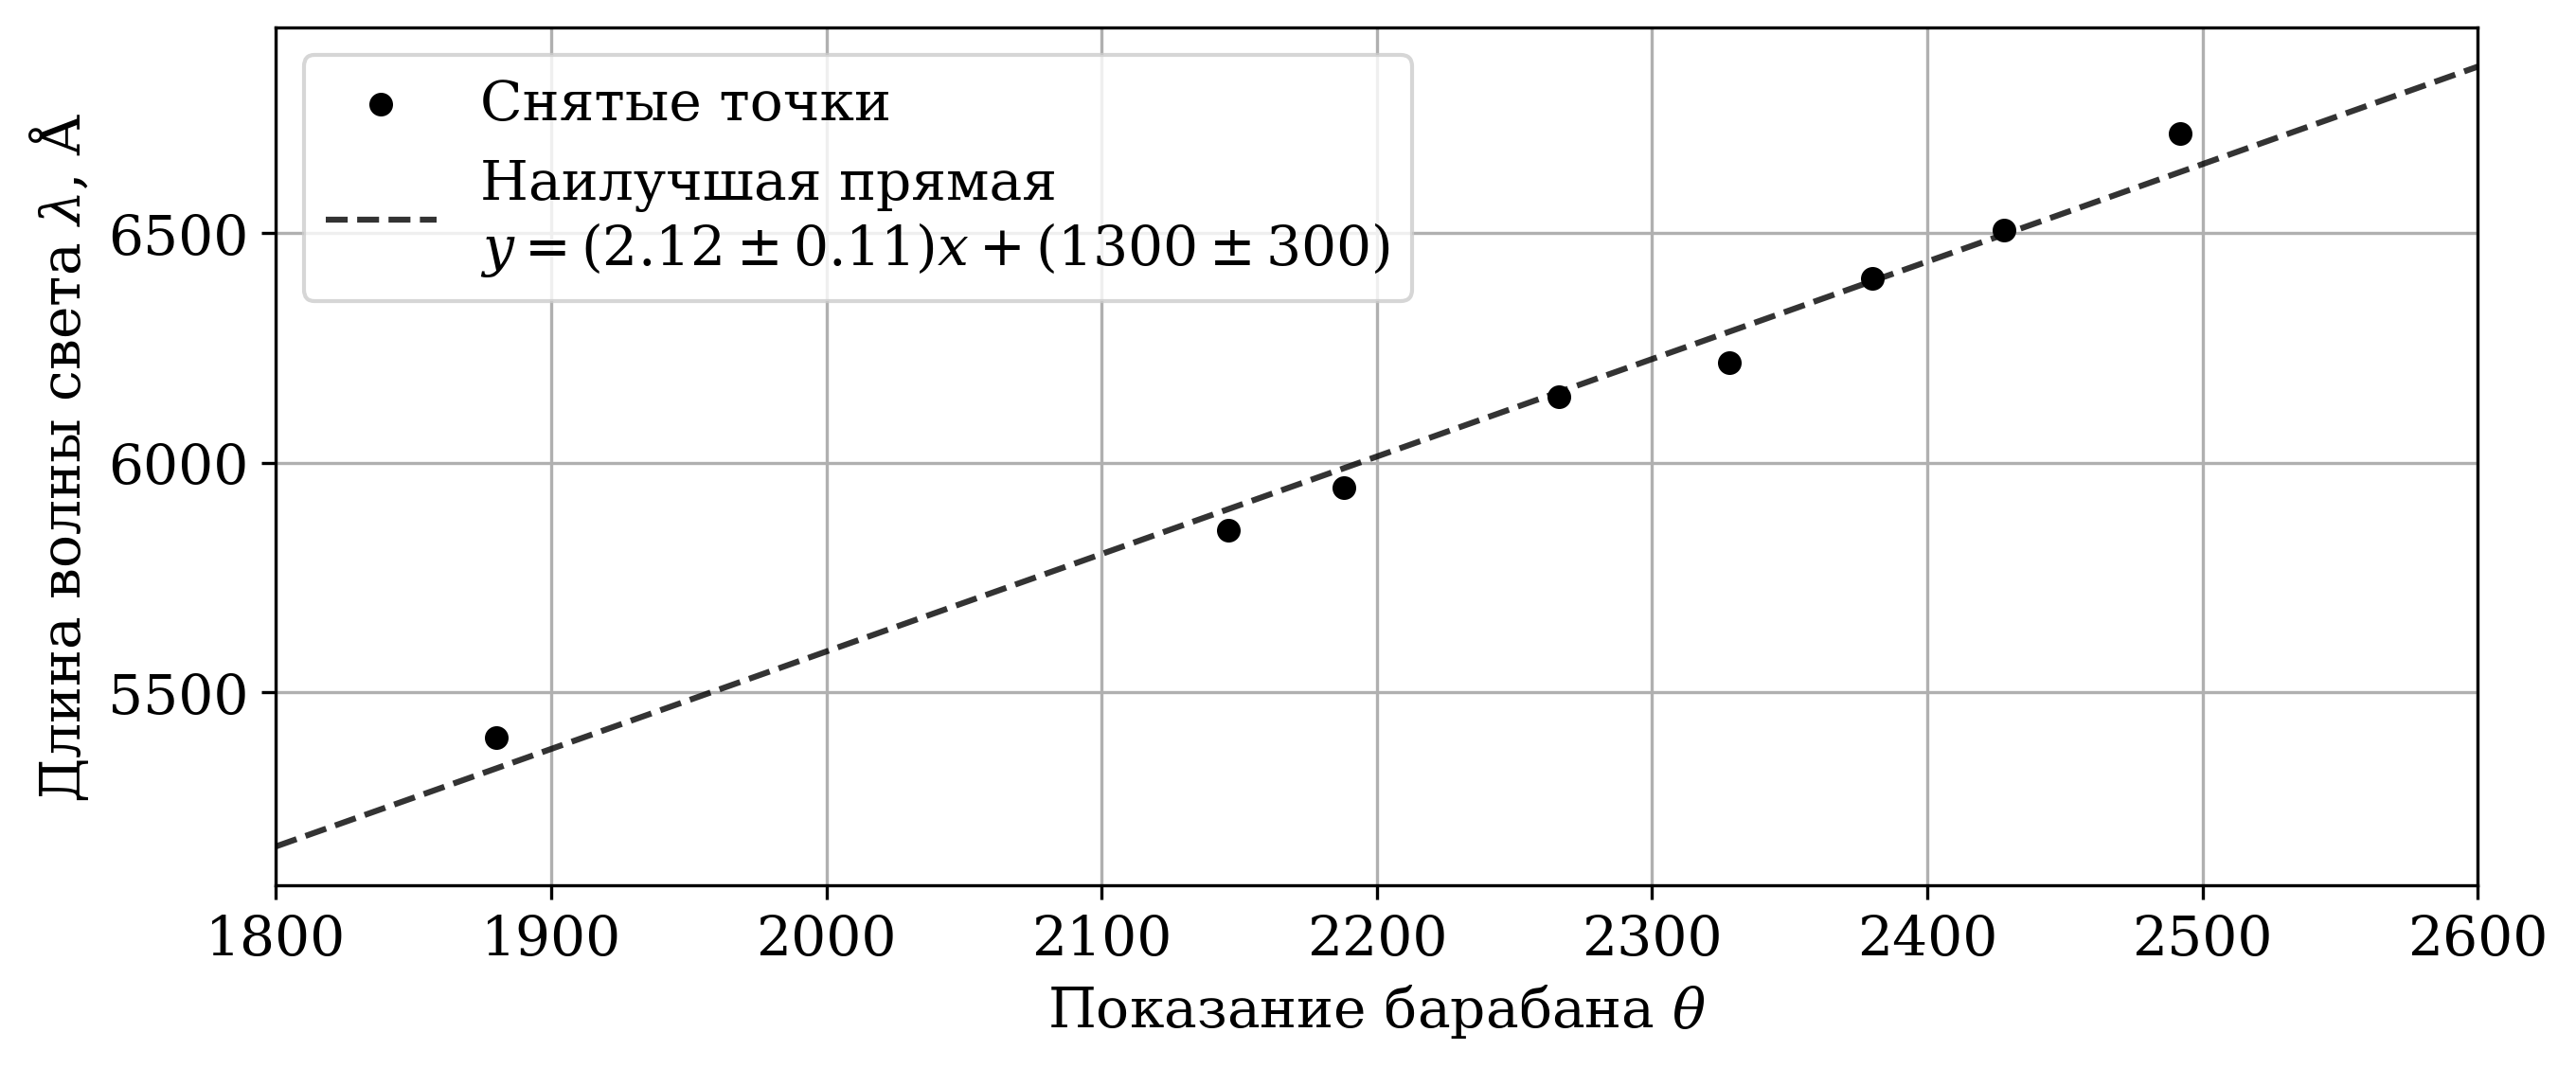

In [13]:
plt.figure(figsize=(10, 4))

x = np.linspace(1800, 2600, 100)

plt.scatter(calibration.deg, calibration.length, marker='.', color='black', zorder=3, s=100, label="Снятые точки")
arg, cov = np.polyfit(calibration.deg, calibration.length, 1, cov=True)
err = np.sqrt(cov.diagonal())
print(arg, err)
calib_f = np.poly1d(arg)
def calib_err_f(x):
    return np.sqrt((x * err[0]) ** 2 + (err[1]) ** 2)
calib_text = f"$y = ({arg[0]:.2f}\pm{err[0]:.2f}) x + ({np.round(arg[1], -2):.0f} \pm {np.round(err[1], -2):.0f})$"
plt.plot(x, calib_f(x), ls='--', color='black', alpha=0.8, label=("Наилучшая прямая\n" + calib_text))

plt.xlabel("Показание барабана $\\theta$")
plt.ylabel("Длина волны света $\lambda$, Å")

plt.xlim(1800, 2600)
plt.legend()
# plt.show()
plt.savefig("plot_calib.pdf")

In [14]:
iu_angles["length"] = np.round(calib_f(iu_angles["angle"]), 0)
iu_angles["error"] = np.round(calib_err_f(iu_angles["angle"]), 0)
iu_angles

,number,angle,length,error
0,1,1880,5334.0,334.0
1,2,1780,5121.0,327.0
2,3,1980,5546.0,341.0
3,4,1680,4909.0,320.0
4,5,2080,5758.0,349.0
5,6,1580,4696.0,313.0
6,7,2180,5971.0,356.0
7,8,1480,4484.0,307.0
8,9,2280,6183.0,364.0


# График общего вида

5334.0


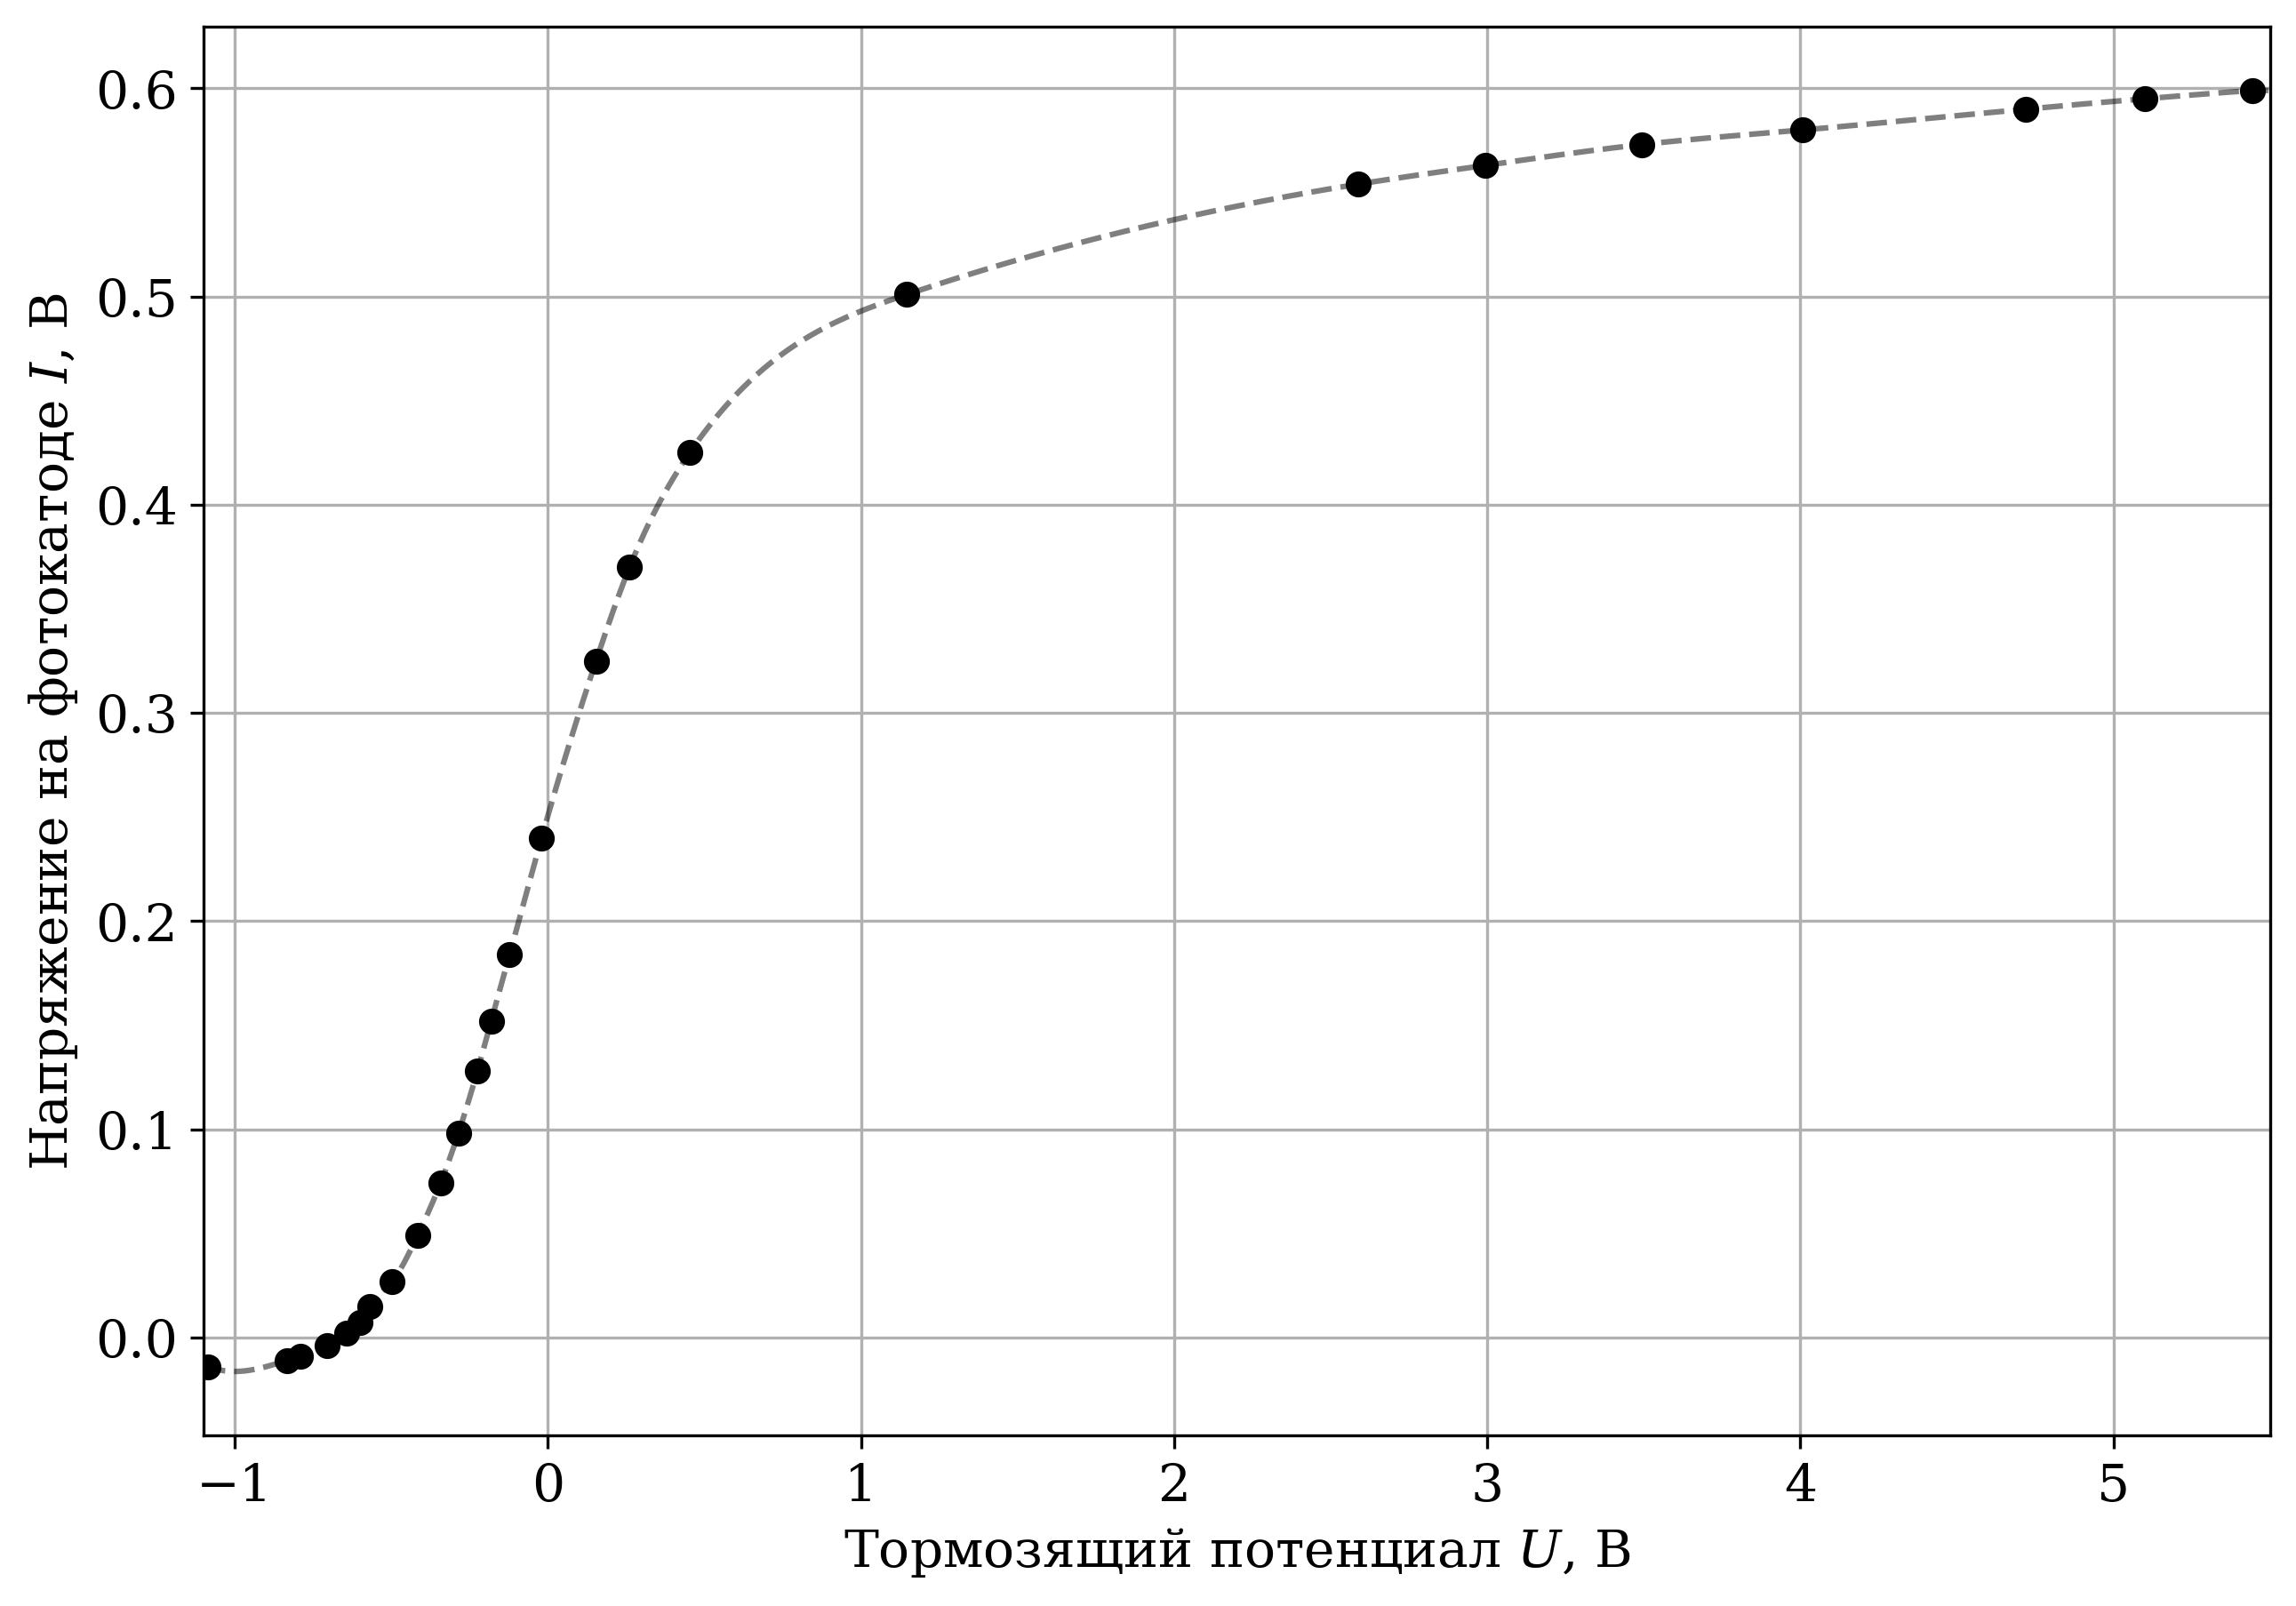

In [15]:
from scipy.interpolate import UnivariateSpline
print(iu_angles.length[0])

x = np.linspace(-2, 6, 1000)
U_530, I_530 = iu_charts.I_1, iu_charts.P_1
sp_530 = UnivariateSpline(U_530, I_530, s=0, ext=3)

plt.scatter(U_530, I_530, color="black", zorder=3)
plt.plot(x, sp_530(x), ls='--', color="black", alpha=0.5)

plt.xlim(-1.1, 5.5)
plt.xlabel("Тормозящий потенциал $U$, В")
plt.ylabel("Напряжение на фотокатоде $I$, В")

plt.savefig("plot_general.pdf")

# Определение запирающего напряжения

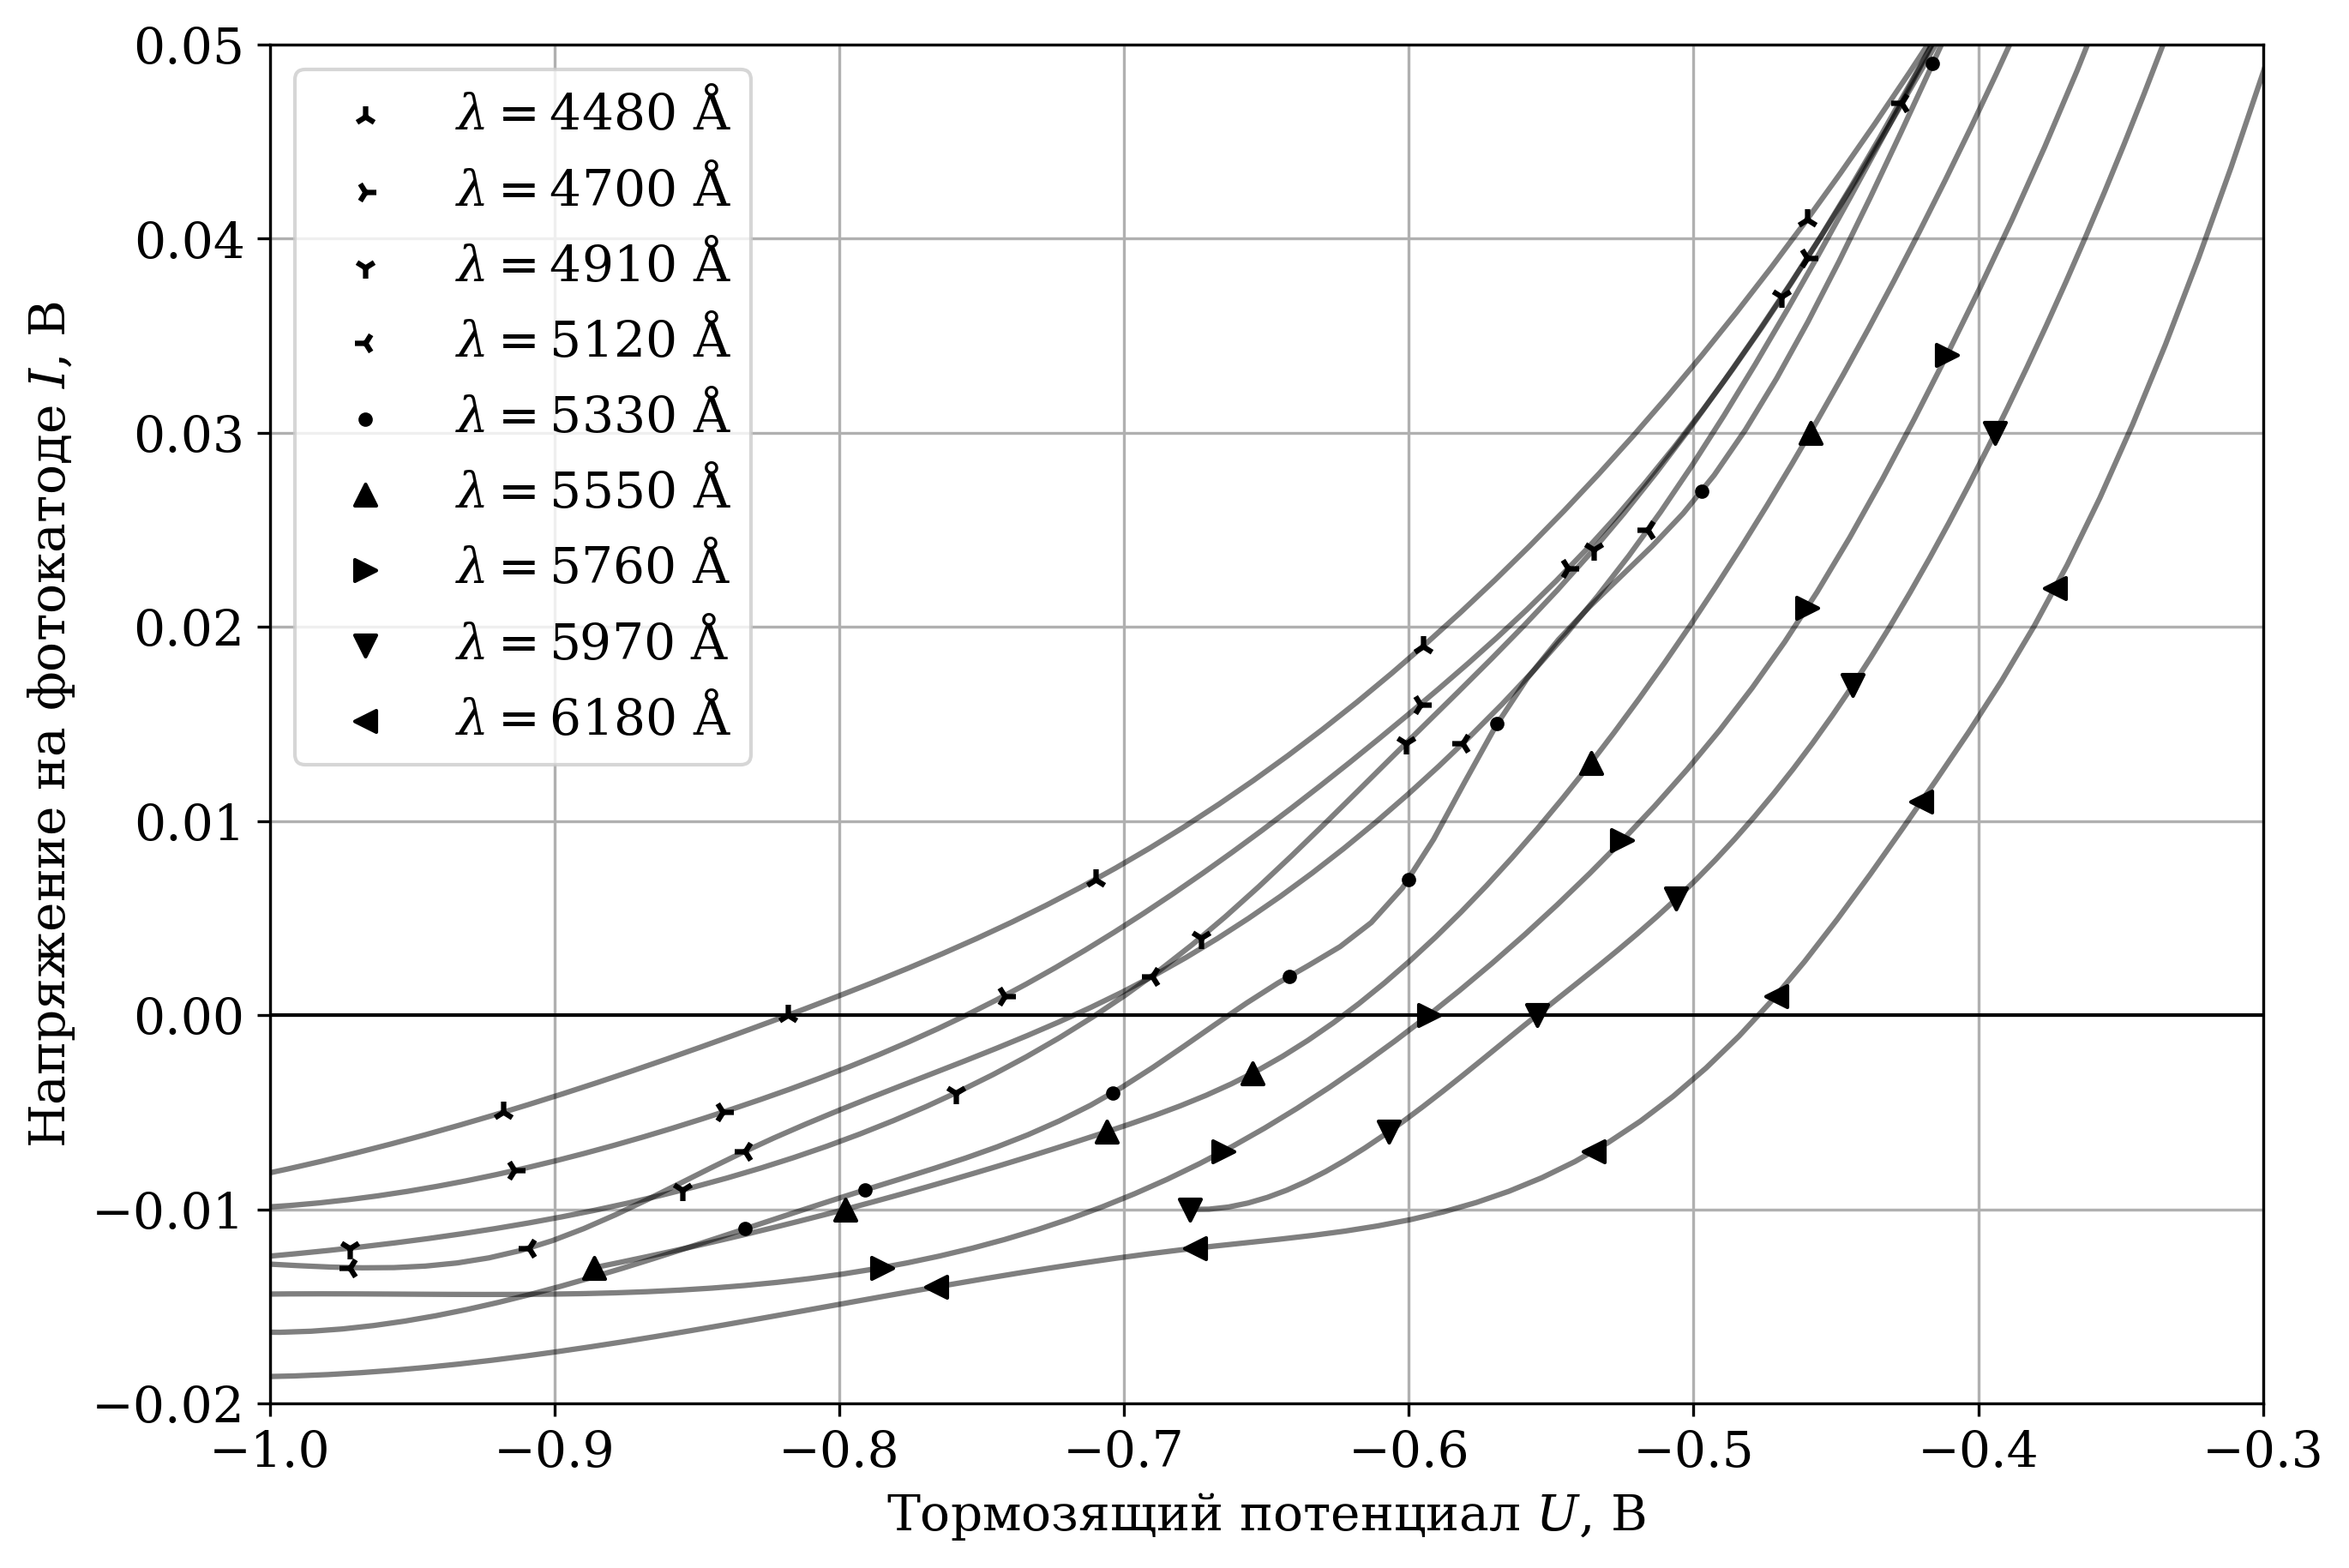

In [16]:
samples_ordering = [8, 6, 4, 2, 1, 3, 5, 7, 9]
markers = ["2", "4", "1", "3", ".", "^", ">", "v", "<"]
for i, m in zip(samples_ordering, markers):
    
    x = np.linspace(min(iu_charts[f"I_{i}"]), 0, 100)
    tmp_s = UnivariateSpline(iu_charts[f"I_{i}"][~np.isnan(iu_charts[f"I_{i}"])], iu_charts[f"P_{i}"][~np.isnan(iu_charts[f"P_{i}"])], s=0)
    plt.plot(x, tmp_s(x), color="black", alpha=0.5)
    plt.scatter(iu_charts[f"I_{i}"], iu_charts[f"P_{i}"], label=f"$\lambda = {np.round(iu_angles['length'][i - 1], -1):.0f}$ Å", zorder=3, marker=m, color="black")
    # plt.plot(iu_charts[f"I_{i}"], iu_charts[f"P_{i}"], color="black", alpha=0.5)
    
plt.plot([-1, 0], [0, 0], color="black", lw=1)
plt.xlim(-1, -0.3)
plt.ylim(-0.02, 0.05)

plt.xlabel("Тормозящий потенциал $U$, В")
plt.ylabel("Напряжение на фотокатоде $I$, В")
plt.legend()

plt.savefig("plot_ends.pdf")

Рассчёт точки пересечения с нулём  
$y = ax + b$  
$x_0 = - \frac{b}{a}$  
$\Delta x_0 = x_0 \sqrt{\left( \frac{\Delta a}{a} \right) ^ 2 + \left( \frac{\Delta b}{b} \right) ^ 2}$


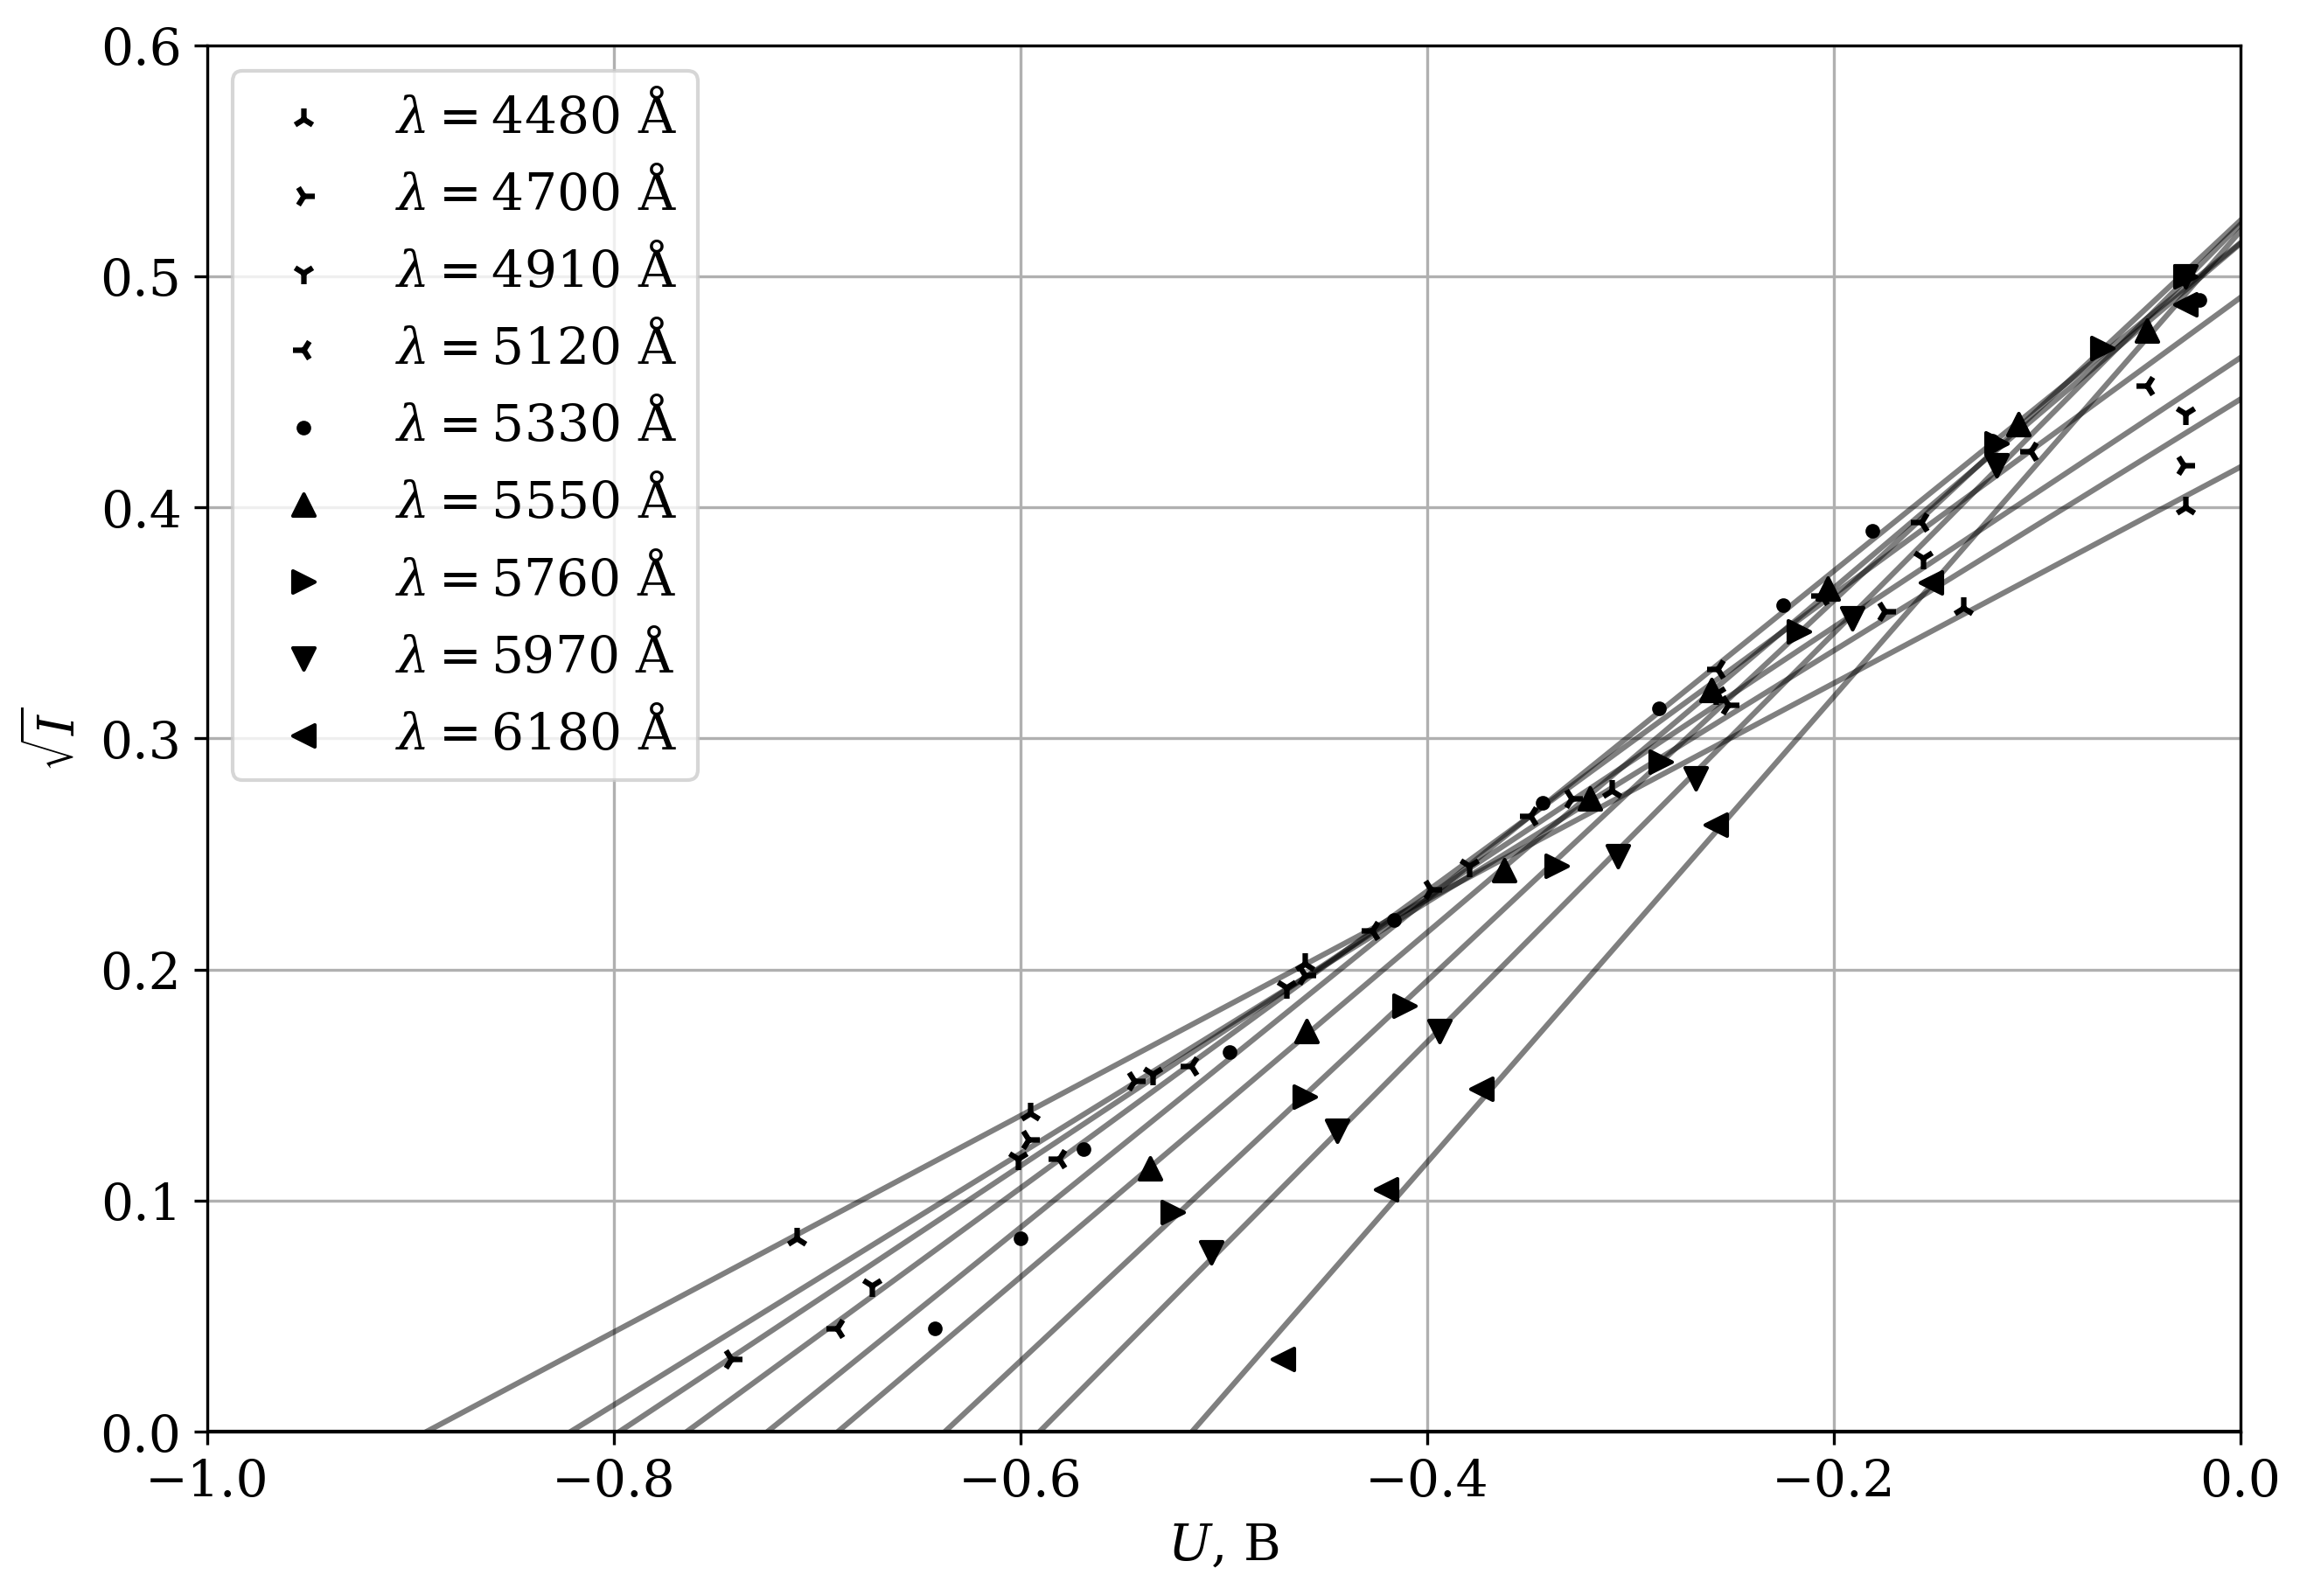

In [17]:
samples_ordering = [8, 6, 4, 2, 1, 3, 5, 7, 9]
markers = ["2", "4", "1", "3", ".", "^", ">", "v", "<"]
round_n = [2, 2, 2, 3, 2, 3, 3, 3, 2]
x = np.linspace(-1, 0, 100)
zeros = []

for i, m, rou in zip(samples_ordering, markers, round_n):
    U, I = iu_charts[f"I_{i}"][~np.isnan(iu_charts[f"I_{i}"])], iu_charts[f"P_{i}"][~np.isnan(iu_charts[f"P_{i}"])]
    U, I = U[U < 0], I[U < 0]
    U, I = U[U > -1], I[U > -1]
    I_sq = np.sqrt(np.abs(I)) * np.sign(I)
    U, I_sq = U[I_sq > 0], I_sq[I_sq > 0]   
    # U, I_sq = U[I_sq < 0.15], I_sq[I_sq < 0.15]
    
    arg, cov = np.polyfit(U, I_sq, 1, cov=True)
    err = np.sqrt(cov.diagonal())
    zero = - arg[1] / arg[0]
    zero_err = zero * np.sqrt((err[0]/arg[0]) ** 2 + (err[1]/arg[1]) ** 2)
    zeros.append((zero, zero_err, iu_angles['length'][i - 1]))
    plt.plot(x, np.polyval(arg, x), color="black", alpha=0.5)
    plt.scatter(U, I_sq, 
                label=f"$\lambda = {np.round(iu_angles['length'][i - 1], -1):.0f}$ Å", 
                zorder=3, marker=m, color='black')
    
    
plt.plot([-1, 0], [0, 0], color="black", lw=1)
plt.xlim(-1, 0)
plt.ylim(0, 0.6)

plt.xlabel("$U$, В")
plt.ylabel("$\sqrt{I}$")
plt.legend()

plt.savefig("plot_roots.pdf")

In [18]:
np.round(np.abs(pd.DataFrame(zeros)), 3).to_csv("u_0.csv")

# Определение постоянной Планка

In [19]:
import scipy.constants as spc
U_0 = np.abs(np.array(zeros)[:, 0])
U_0_err = np.abs(np.array(zeros)[:, 1])
omega_0 = 2 * np.pi * spc.c / np.array(zeros)[:, 2] * 1e10
omega_0_err = omega_0 * (calib_err_f(np.array(zeros)[:, 2]) / np.array(zeros)[:, 2])

[ 3.06146243e-16 -3.78042796e-01] [2.37400923e-17 8.34031357e-02]
3.061462432416607e-16 2.3740092295071893e-17
-0.3780427963683647 0.08340313569338582


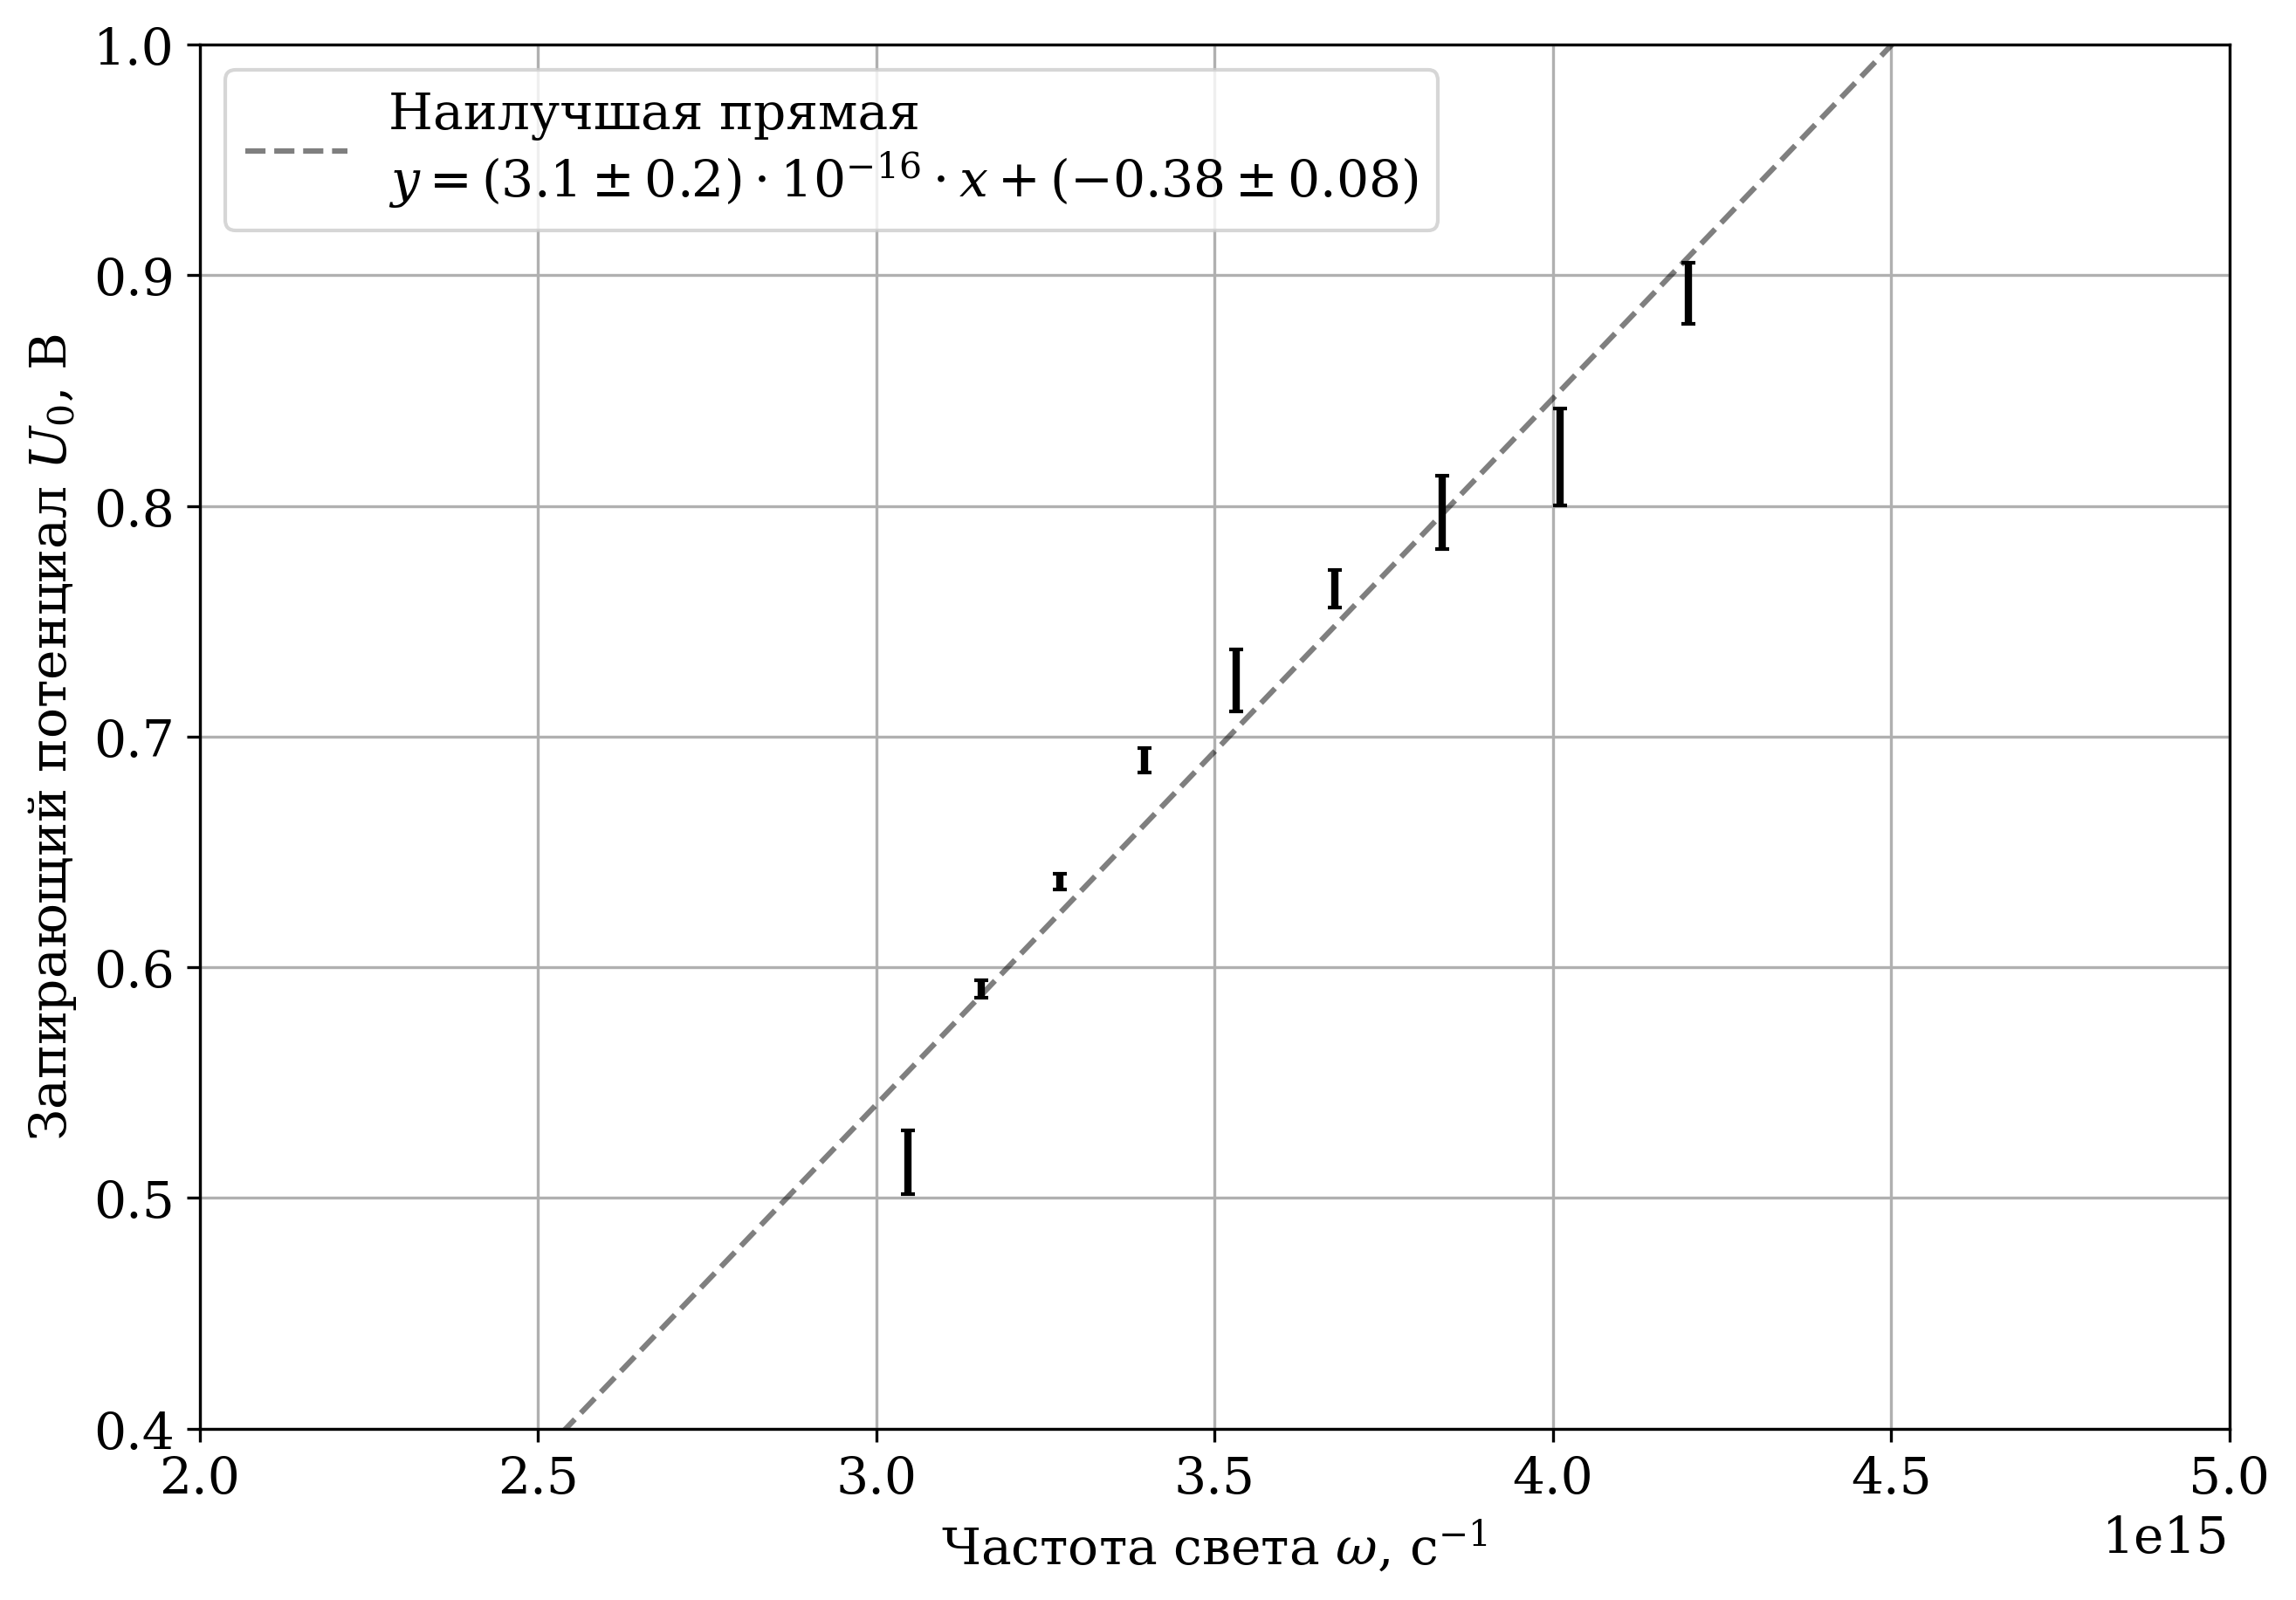

In [20]:
x = np.linspace(0, 5e15, 100)
plt.errorbar(omega_0, U_0, yerr=(U_0_err), xerr=0, fmt='none', capsize=2, lw=2, color="black")
arg, cov = np.polyfit(omega_0, U_0, 1, w=1/omega_0_err, cov=True)
err = np.sqrt(cov.diagonal())
print(arg, err)
print(arg[0], err[0])
print(arg[1], err[1])

line_text = f"$y = ({arg[0] * 1e16:.1f}\pm{err[0] * 1e16:.1f}) \cdot 10^{{-16}} \cdot x + ({arg[1]:.2f} \pm {err[1]:.2f})$"
plt.plot(x, np.polyval(arg, x), color="black", alpha=0.5, ls='--', label="Наилучшая прямая\n" + line_text)

plt.ylim(0.4, 1)
plt.xlim(2e15, 5e15)
plt.xlabel("Частота света $\omega$, с$^{-1}$")
plt.ylabel("Запирающий потенциал $U_0$, В")
plt.legend()
plt.savefig("plot_plank.pdf")

$\frac{dU_0}{d\omega} = \alpha = 2.68 \cdot 10^{-16}$  
$\Delta \alpha = 0.22 \cdot 10^{-16}$  
$\frac{\hbar}{e} = 2.7 \cdot 10^{-16}$  
$\hbar = e \cdot 2.7 \cdot 10^{-16}$  